<a href="https://colab.research.google.com/github/basarr/gold-regime-risk/blob/main/Gold_Regime_Risk_Monitor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gold Regime Risk Monitor (GLD)
Goal: Train a probabilistic model to estimate the chance of a ≥10% drawdown in the next 90 trading days.
- Train/Test evaluation uses only rows where the future 90-day window is known.
- The last ~90 trading days have unknown outcomes, so they are used only for "live" probability scoring.
This is educational; probabilities can be wrong and are not trading signals.

In [1]:
!pip -q install yfinance pandas numpy matplotlib scikit-learn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, brier_score_loss

## Step 2 — Download data (GLD) and build `g`
We use GLD (gold ETF proxy) via Yahoo Finance. We keep only the adjusted `close`.
We also flatten columns in case yfinance returns a MultiIndex.

In [2]:
symbol = "GLD"
start = "2006-01-01"

df = yf.download(symbol, start=start, auto_adjust=True, progress=False)

# Flatten columns
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

df.columns = [c.lower() for c in df.columns]

# Clean single-series dataframe
g = df[["close"]].copy()
g.index = pd.to_datetime(g.index)

print("Start:", g.index.min().date(), "End:", g.index.max().date(), "Rows:", len(g))
g.tail()

Start: 2006-01-03 End: 2026-01-27 Rows: 5048


,close
Date,
2026-01-21,443.600006
2026-01-22,451.790009
2026-01-23,458.000000
2026-01-26,464.700012
2026-01-27,476.100006


## Step 3 Sanity checks
We confirm the dataset is recent and the last date is close to today (last trading day).

Last available date: 2026-01-27 00:00:00
Days since last data point: 1


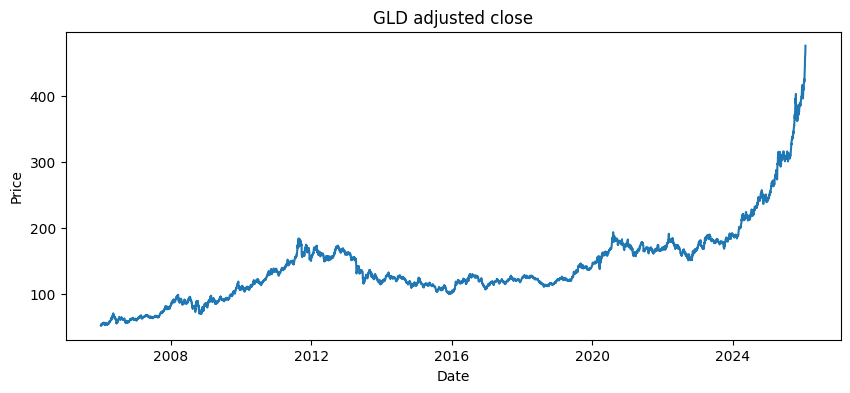

In [3]:
last_date = g.index.max()
print("Last available date:", last_date)
print("Days since last data point:", (pd.Timestamp.today() - last_date).days)

plt.figure(figsize=(10,4))
plt.plot(g.index, g["close"])
plt.title(f"{symbol} adjusted close")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

## Step 4 — Returns + features
We create transparent, price-based features:
- `ret_1d`: daily log return
- `vol_20d`, `vol_60d`: rolling volatility (annualized)
- `mom_20d`, `mom_60d`: rolling log momentum
- `z_252`: distance from 1-year rolling mean, in std units

In [4]:
g = g.copy()
g["ret_1d"] = np.log(g["close"]).diff()

# Volatility (annualized)
g["vol_20d"] = g["ret_1d"].rolling(20).std() * np.sqrt(252)
g["vol_60d"] = g["ret_1d"].rolling(60).std() * np.sqrt(252)

# Momentum (log return over window)
g["mom_20d"] = np.log(g["close"]).diff(20)
g["mom_60d"] = np.log(g["close"]).diff(60)

# Z-score (1 year)
roll = 252
mu = g["close"].rolling(roll).mean()
sd = g["close"].rolling(roll).std()
g["z_252"] = (g["close"] - mu) / sd

g.tail()

,close,ret_1d,vol_20d,vol_60d,mom_20d,mom_60d,z_252
Date,,,,,,,
2026-01-21,443.600006,0.014464,0.267546,0.203606,0.105912,0.157941,2.506406
2026-01-22,451.790009,0.018294,0.264075,0.205709,0.101387,0.179594,2.640009
2026-01-23,458.000000,0.013652,0.264278,0.196244,0.101873,0.221480,2.725997
2026-01-26,464.700012,0.014523,0.263931,0.196146,0.120539,0.243195,2.816740
2026-01-27,476.100006,0.024236,0.271179,0.199735,0.133165,0.271225,2.993552


## Step 5 — Spike flag
We define a simple “spike” regime:
- `is_spike = 1` if 60-day momentum is in the top 10% of history
This is not a prediction; just a regime indicator.

In [6]:
spike_threshold = g["mom_60d"].quantile(0.90)
g["is_spike"] = (g["mom_60d"] >= spike_threshold).astype(int)

print("Spike threshold (mom_60d):", spike_threshold)
print("Spike share:", g["is_spike"].mean())

Spike threshold (mom_60d): 0.12501457776236702
Spike share: 0.09885103011093502


## Step 6 — Target label (downfall in next 90 trading days)
We define:
- Horizon `h = 90` trading days
- Downfall event if the minimum price in the NEXT 90 days is ≤ -10% below today.

Important:
- For the last ~90 days, the future is unknown → label is NaN there.
- Those rows will be used only for "live" scoring later.

In [8]:
h = 90
dd_cut = -0.10

# Forward-looking min over next h days (t+1 ... t+h)
future_min = (
    g["close"].shift(-1)[::-1]
    .rolling(h, min_periods=h).min()
    [::-1]
)

g["future_dd_90d"] = (future_min / g["close"]) - 1.0
g["y_downfall_90d"] = (g["future_dd_90d"] <= dd_cut).astype(int)

print("NaNs in last 90 rows:", g["future_dd_90d"].tail(90).isna().sum())
g[["close","future_dd_90d","y_downfall_90d"]].tail(10)

NaNs in last 90 rows: 90


,close,future_dd_90d,y_downfall_90d
Date,,,
2026-01-13,421.630005,NaN,0
2026-01-14,425.940002,NaN,0
2026-01-15,423.329987,NaN,0
2026-01-16,421.290009,NaN,0
2026-01-20,437.230011,NaN,0
2026-01-21,443.600006,NaN,0
2026-01-22,451.790009,NaN,0
2026-01-23,458.000000,NaN,0
2026-01-26,464.700012,NaN,0


## Step 7 — Two datasets
A) `g_train`: rows where the future 90-day outcome is known (used for training/testing evaluation)  
B) `g_live`: rows where features exist (includes last 90 days; used for live probability scoring)

In [9]:
features = ["vol_20d","vol_60d","mom_20d","mom_60d","z_252","is_spike"]

g_train = g.dropna(subset=features + ["future_dd_90d"]).copy()
g_live  = g.dropna(subset=features).copy()

print("Rows (trainable):", len(g_train))
print("Rows (live):     ", len(g_live))
print("Live includes last date:", g_live.index.max().date())

Rows (trainable): 4707
Rows (live):      4797
Live includes last date: 2026-01-27


## Step 8 — 80/20 time split (chronological)
We split the trainable dataset into:
- first 80% time = train
- last 20% time = test
No random shuffling (to avoid leaking future into past).

In [10]:
X = g_train[features]
y = g_train["y_downfall_90d"]

split = int(0.8 * len(g_train))
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

print("Train period:", X_train.index.min().date(), "→", X_train.index.max().date(), "Rows:", len(X_train))
print("Test period: ", X_test.index.min().date(), "→", X_test.index.max().date(), "Rows:", len(X_test))

Train period: 2007-01-03 → 2021-12-14 Rows: 3765
Test period:  2021-12-15 → 2025-09-17 Rows: 942


## Step 9 — Baseline probabilistic model (Logistic Regression)
We fit a simple model that outputs probabilities.
Evaluation metrics:
- AUC: discrimination ability (0.5 ≈ random)
- Brier score: probability accuracy (lower is better)
Finance is noisy; weak scores are common and still informative.

In [11]:
clf = LogisticRegression(max_iter=3000)
clf.fit(X_train, y_train)

p_test = clf.predict_proba(X_test)[:, 1]

print("Test AUC:", roc_auc_score(y_test, p_test))
print("Test Brier:", brier_score_loss(y_test, p_test))

Test AUC: 0.6592517401392112
Test Brier: 0.08439346157982326


## Step 10 — Plot probabilities on the test period
This shows how the model's risk estimate changes over time in the unseen test window.

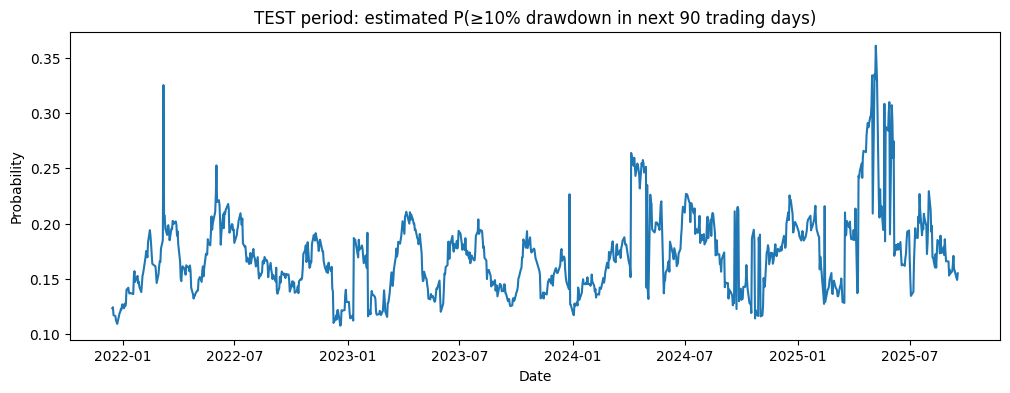

In [12]:
out_test = g_train.iloc[split:].copy()
out_test["p_downfall_90d"] = p_test

plt.figure(figsize=(12,4))
plt.plot(out_test.index, out_test["p_downfall_90d"])
plt.title("TEST period: estimated P(≥10% drawdown in next 90 trading days)")
plt.ylabel("Probability")
plt.xlabel("Date")
plt.show()

## Step 11 — Live scoring (includes last ~90 days)
Now we compute probabilities for all rows with features, including recent dates where the label is unknown.
This is what our "tool" would show today.

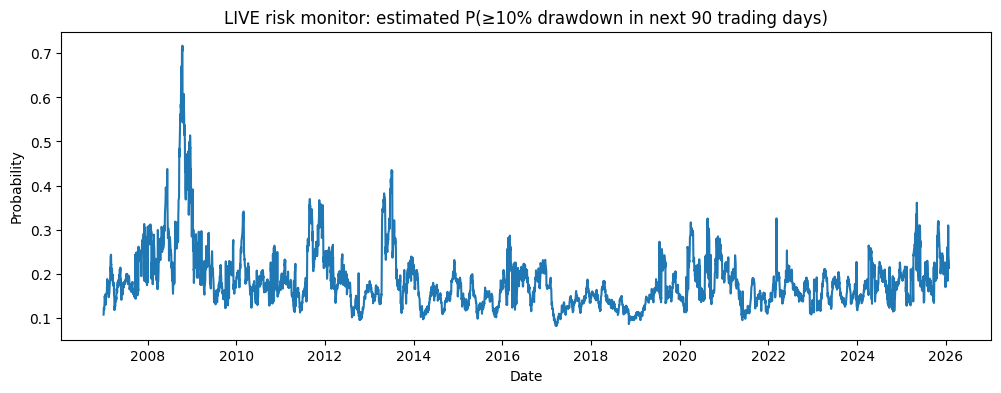

,close,p_downfall_90d,is_spike,mom_60d,vol_20d,z_252
Date,,,,,,
2026-01-13,421.630005,0.249041,0,0.061578,0.232560,2.168892
2026-01-14,425.940002,0.224337,0,0.090745,0.233668,2.237780
2026-01-15,423.329987,0.260653,0,0.048843,0.235997,2.157326
2026-01-16,421.290009,0.183711,0,0.110440,0.236864,2.090891
2026-01-20,437.230011,0.309572,1,0.147472,0.265666,2.404348
2026-01-21,443.600006,0.307200,1,0.157941,0.267546,2.506406
2026-01-22,451.790009,0.284535,1,0.179594,0.264075,2.640009
2026-01-23,458.000000,0.239879,1,0.221480,0.264278,2.725997
2026-01-26,464.700012,0.226213,1,0.243195,0.263931,2.816740


In [13]:
g_live = g_live.copy()
g_live["p_downfall_90d"] = clf.predict_proba(g_live[features])[:, 1]

plt.figure(figsize=(12,4))
plt.plot(g_live.index, g_live["p_downfall_90d"])
plt.title("LIVE risk monitor: estimated P(≥10% drawdown in next 90 trading days)")
plt.ylabel("Probability")
plt.xlabel("Date")
plt.show()

g_live[["close","p_downfall_90d","is_spike","mom_60d","vol_20d","z_252"]].tail(10)

## Step 12 — Calibration (are probabilities honest?)
We bin predicted probabilities and compare:
- average predicted probability in the bin
vs
- actual event frequency in the bin
This checks whether “30%” really behaves like ~30% historically (in test).

In [14]:
tmp = out_test[["p_downfall_90d","y_downfall_90d"]].dropna().copy()
tmp["bin"] = pd.qcut(tmp["p_downfall_90d"], q=10, duplicates="drop")

cal = tmp.groupby("bin").agg(
    avg_pred=("p_downfall_90d","mean"),
    freq=("y_downfall_90d","mean"),
    n=("y_downfall_90d","size")
).reset_index(drop=True)

cal

/tmp/ipython-input-643228497.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cal = tmp.groupby("bin").agg(


,avg_pred,freq,n
0,0.122252,0.000000,95
1,0.136563,0.053191,94
2,0.145317,0.042553,94
3,0.154424,0.074468,94
4,0.163795,0.106383,94
5,0.172596,0.031915,94
6,0.181256,0.085106,94
7,0.190184,0.127660,94
8,0.201916,0.212766,94
9,0.248648,0.115789,95


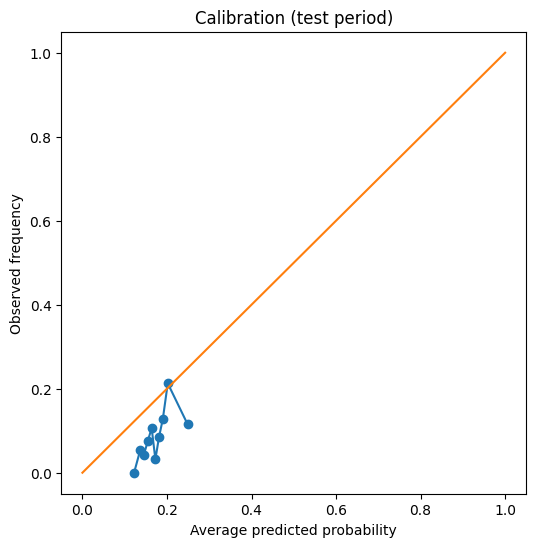

In [15]:
plt.figure(figsize=(6,6))
plt.plot(cal["avg_pred"], cal["freq"], marker="o")
plt.plot([0,1],[0,1])
plt.title("Calibration (test period)")
plt.xlabel("Average predicted probability")
plt.ylabel("Observed frequency")
plt.show()